# Prediction the median price of houses in California districts

## Metadate

**Created by**: Arkadiusz Morawiec

**Date**: 29.06.2024 #DD.MM.YYYY

**Goal**: Predicting the houses median price basen od data

**Description**: This notebook describe step by step how to build a process prediction model.

**version**: 1.0

## Data information

Data comes from `StatLib` repository and are based on the 1990 California consus.

The goal of the project will be create a regression model to predict the district's median house price.

## Selection of models and metrics

**Models**:

In this project I will use the next regression models:
1. **Linear regression:** For simplicity and interpretablity.
2. **Decision Trees:** - To capture potential non-regresion relationship in the data
3. **Random Forest:** - To improve accuray and reduce overfitting.
4. **Gradient Boosting (XGBoost/CatBoost):** - For achieving high predicitve accuracy.

**Metrics**
To assess the performance of our models, we will use the following metrics:
1. **MAE (Mean Absolute Error):** - The average absolute difference between actual and predictive values.
2. **MSE (Mean Square Error)** - The average square difference between actual and predictive values.
3. **RMSE (Root Mean Squared Error** - The square root of MSE, interpreted as the typical prediction error.
4. **R^2 (Coefficient of Determination)** - The proportion of variance explained by the model.

## Setup Enviroment

In [1]:
# importing necessery libraries

## data preprocessing, read, transforming
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)

## Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot') #https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html

## Models, Metrics, Processing, Encoders, Split data
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import eli5

## ReadData

In [2]:
def readDataSet():
    from pathlib import Path
    Path = Path("./housing/")
    file_name = "housing.csv"
    CaliforniaDf = pd.read_csv(Path.joinpath(file_name))
    return CaliforniaDf

In [3]:
df = readDataSet()

# Data Understanding

### Data desctiption

Dataset consists of 20640 entries and 10 columns:

1. **longitude** - A measure of how far west a house is
2. **latitude** - A measure of how far north a house is;
3. **housing_median_age** - Median age of a house within a block; a lower number is a newer building
4. **total_rooms** - Total number of rooms within a block
5. **total_bedrooms** - Total number of bedrooms within a block
6. **population** - Total number of people residing within a block
7. **households** - Total number of households, a grouop of people residin within a home unit for a block
8. **median_income** - Median income for household within a block of houses (measured in tens of thousands of US $)
9. **median_house_value** - Median house value for households with a block (measured in US Dollars)
10. **ocean_proximity** - Location of the house at a distance from ocean (category)

## First glance of data

In [4]:
df.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## Check types

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In data set we have:

- 9 float feature: (Numerical)
    - Continous data:
        - longitude
        - latitude
        - median_income
    - Discrete:
        - housing_median_age
        - total_rooms
        - total_bedroms
        - population
        - households
        - median_house_value
- 1 object: (Categorical):
    - Oridinal:
        - ocean_proximity 

In [6]:
df['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [7]:
df.shape[0]

20640

## Check nulls

In [8]:
dfNulls = df.isnull().sum().to_frame(name='ct')
dfNulls['%'] = ((dfNulls['ct']/df.shape[0]) * 100.0).round(3)
dfNulls

,ct,%
longitude,0,0.000
latitude,0,0.000
housing_median_age,0,0.000
total_rooms,0,0.000
total_bedrooms,207,1.003
population,0,0.000
households,0,0.000
median_income,0,0.000
median_house_value,0,0.000
ocean_proximity,0,0.000


One variable has null values: **total_bedrooms** (207 : 1.003%)

## Check duplicates

In [9]:
df[df.duplicated(subset=['longitude','latitude','population','median_house_value'], keep=False)]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity


**NO DUPLICATE ROWS IN DATASET**

## Basic stats

### Numeric Variables

In [10]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


**Longitude/Latitude**
- Probably no outliers, data is in cluster, mean is close to the median and std is insignificant+

**housing_median_age**: 
- Looking at median and mean it could be nornmal distribution. 
- A high value of deviation from the mean indicates data diversity. 
- large range of data suggest the occurrence of outlers

**total_rooms**:
- mean is highest than median so it suggets the distribution is right skrew.
- Outliers could occurence because range of data is much too big for std (range: 2-39320; std: 2181), 3std limit is: 2635 + 3*2181 = 9178

**total_bedrooms**:
- mean is higest then median so it suggets the distribution is right skrew.
- High value of deviation suggest large variance (we have range 1-6445))
- Outliers can occurence if we look at 75 percentile and we will compare it with the max value

**pupulation**
- mean is higest then median so it suggets the distribution is right long skrew.
- Outliers can occurence if we look at 75 percentile and we will compare it with the max value
- range 3-35682

**households**:
- mean is higest then median so it suggets the distribution is right long skrew.,
- Outliers can occurence if we look at 75 percentile and we will compare it with the max value

**median_income**
- mean is higest then median so it suggets the distribution is right skrew, but not much
- range is 0.5-15

**median_house_value:**
- mean is higest then median so it suggets the distribution is right skrew.
- high range 15k-500k

### Categorical Variables

In [11]:
df.describe(exclude='number')

,ocean_proximity
count,20640
unique,5
top,<1H OCEAN
freq,9136


We have only one Cat variable.

**ocean_proximity:**
- 5 unique values
- top (9136) is "1H OCENA"

# EDA (Exploratory Data Analysis)

In [12]:
df_org = df.copy() ## We create copies of the data because we will perform various transfroamtion to visualize the data

## Distribution of data

In [13]:
df.select_dtypes(['object','category']).columns

Index(['ocean_proximity'], dtype='object')

In [14]:
numerical_feautres = df.select_dtypes('number').columns
print(numerical_feautres)

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value'],
      dtype='object')


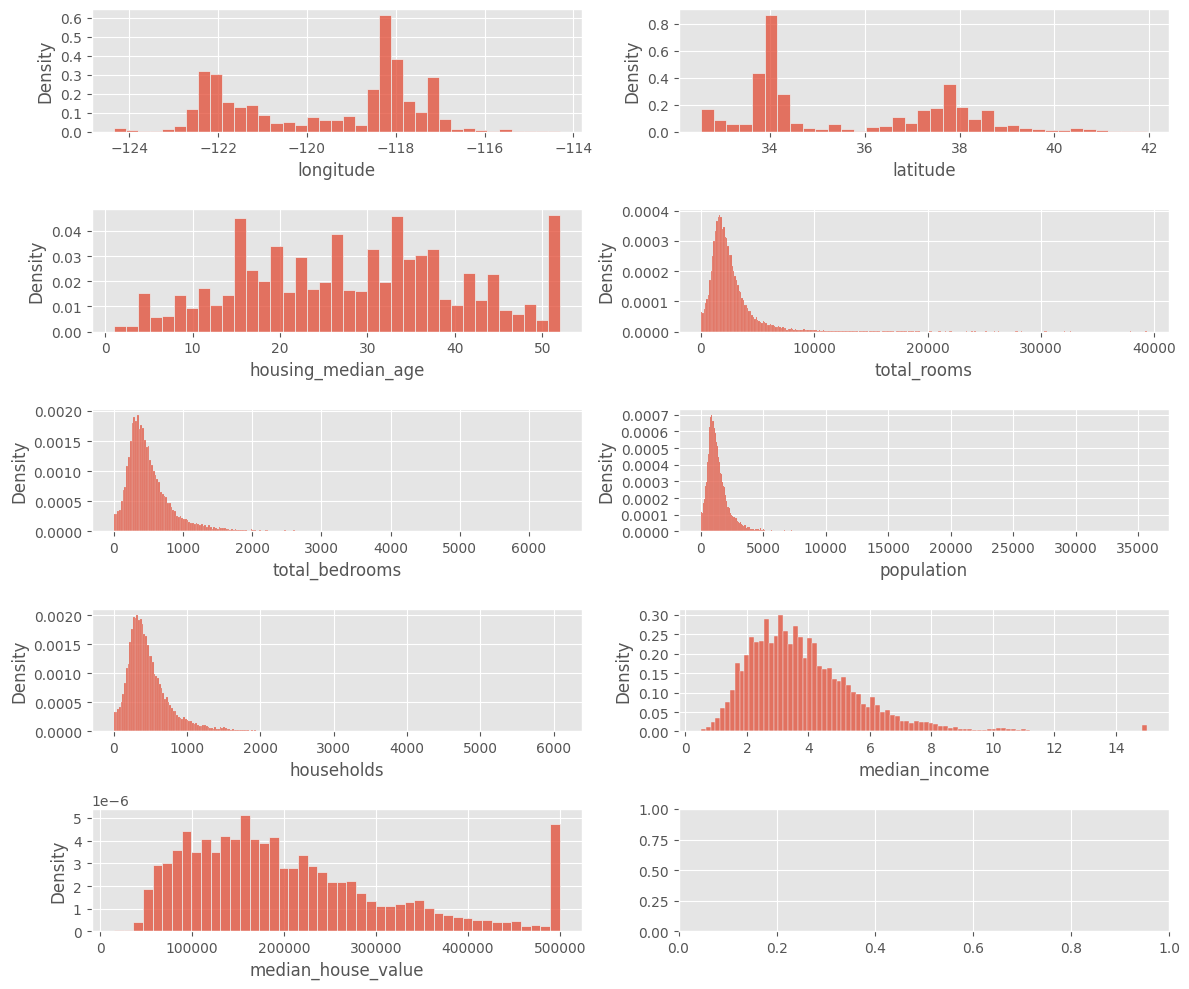

In [15]:
ncol = 2
nrows = len(numerical_feautres) // ncol + len(numerical_feautres) % ncol
fig, axes = plt.subplots(nrows=nrows, ncols=ncol, figsize=(12,2*nrows))

axes = axes.flatten()

for ax, col in zip(axes, numerical_feautres):
    sns.histplot(df, x=col, ax=ax, stat='density')
    ax.locator_params(axis='both', nbins=8)

plt.tight_layout()
plt.show()

In area of **logitute** ~ -122/-118 and **latitude** ~35/37 we have clusters of houses. - We need to calculate rbf kernal from this clusters

**Housing_median_age** is multimodal data and probablity is clipped to ~51.

**Total rooms** is long right skrew distribution with a peak in the 2k area We need log10 if >0 or log1p if >=0

**Total bedrooms** long right skrew distribution with a peak in the ~280 value. We need log10...

**Households** Long right skrew distribution with a peak in the 450 values. We need log it

**Median income** short right skrew distribution. we can log it.

**Population** - Long right skrew distribution. Peak ~1k

**Median house value** short right skrew distribution with additional peak in last bucket, probably original data has been cliped






## Visualise map of points long and lat

In [16]:
df['Long_lat'] = df['longitude'].round(1).astype('str') + "," + df['latitude'].round(1).astype('str') ## Most freq points Long Lat
df['Long_lat'].value_counts().head(5)

Long_lat
-118.3,34.0    422
-118.2,34.0    360
-118.4,34.0    348
-122.2,37.8    291
-118.4,34.2    289
Name: count, dtype: int64

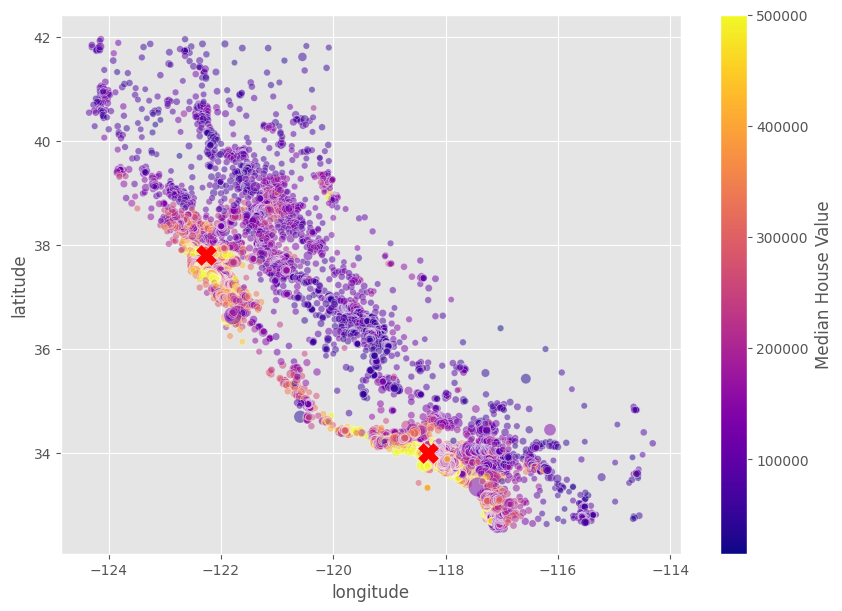

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(10, 7))

# Utworzenie osi dla wykresu
ax = plt.gca()

# Utworzenie wykresu scatter
scatter = sns.scatterplot(
    data=df,
    x="longitude",
    y="latitude",
    size=df["population"] / 100,
    sizes=(20, 200),
    hue="median_house_value",
    palette="plasma",
    ax=ax,
    legend=False,
    alpha=0.5
)

# Dodanie siatki (grid)
plt.grid(True)

# Dodanie paska kolorów (color bar)
norm = plt.Normalize(df["median_house_value"].min(), df["median_house_value"].max())
sm = plt.cm.ScalarMappable(cmap="plasma", norm=norm)
sm.set_array([])  # Wymagane tylko do utworzenia poprawnej skali kolorów
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Median House Value')

## add cluster from above conlusion
x = [-122.27,-118.31]
y = [37.8, 34]
plt.scatter(x=x, y=y, marker="X", color='red', s=200)


# Pokaż wykres
plt.show()



In [18]:
type(sm)

matplotlib.cm.ScalarMappable